In [34]:
import os
import email
from email import policy
from sklearn.cluster import KMeans
from transformers import BertModel, BertTokenizer
from sklearn.cluster import MiniBatchKMeans
from tqdm import tqdm
import numpy as np
from sklearn.manifold import TSNE


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
def read_email_with_progress(file_path):
    with tqdm(total=1, desc='Reading email') as pbar:
        with open(file_path, 'r', encoding='latin-1') as f:
            email_msg = email.message_from_file(f, policy=policy.default)
            pbar.update(1)
    return email_msg

def read_email(file_path):
    with open(file_path, 'r', encoding='latin-1') as f:
        return email.message_from_file(f, policy=policy.default)
def extract_text_with_progress(email_msg):
    if email_msg.is_multipart():
        parts = [part for part in email_msg.iter_parts() if part.get_content_type() == 'text/plain']
        total_parts = len(parts)
        text = ''
        with tqdm(total=total_parts, desc='Extracting text') as pbar:
            for part in parts:
                text += part.get_payload(decode=True).decode('latin-1')
                pbar.update(1)
        return text
    else:
        return email_msg.get_payload(decode=True).decode('latin-1')
    
    
def extract_text(email_msg):
    if email_msg.is_multipart():
        return ''.join(part.get_payload(decode=True).decode('latin-1') for part in email_msg.iter_parts() if part.get_content_type() == 'text/plain')
    else:
        return email_msg.get_payload(decode=True).decode('latin-1')

def encode_text(text):
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True)
    outputs = model(**inputs)
    return outputs.last_hidden_state[:,0,:].detach().numpy()

def encode_text_with_progress(text):
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True)
    outputs = model(**inputs)
    return tqdm(outputs.last_hidden_state[:,0,:].detach().numpy(), desc='Encoding text')

In [ ]:
# email_msg = read_email('data/archives-EGC/polytech_liste-egc_archives-2006-2010/polytech_liste-egc_2006-03/4')
# print(extract_text(email_msg))

In [ ]:
email_vectors = []
# for root, dirs, files in tqdm(os.walk('data/archives-EGC/polytech_liste-egc_2009-12'), desc='Processing emails'):
# for root, dirs, files in tqdm(os.walk('data/file_list'), desc='Processing emails'):
#     for file in tqdm(files, desc='Processing files'):
#         if file != '.DS_Store':
#             file_path = os.path.join(root, file)
#             email_msg = read_email(file_path)
#             text = extract_text(email_msg)
#             vector = encode_text(text)
#             email_vectors.append(vector)
#             # tqdm.write(f'Processing file: {file_path}')
            
i = 0
files = os.listdir('data/file_list')
print(len(files))
print(files[0])

In [21]:
import concurrent.futures

def process_file(file):
    if file != '.DS_Store':
        file_path = os.path.join('data/file_list/', file)
        email_msg = read_email(file_path)
        text = extract_text(email_msg)
        vector = encode_text(text)
        return vector
    else:
        return None

files = os.listdir('data/file_list')

# Create a thread pool and have it execute the process_file function on the list of files
with concurrent.futures.ThreadPoolExecutor() as executor:
    email_vectors = list(tqdm(executor.map(process_file, files), total=len(files)))

# Remove None values from the list (corresponding to '.DS_Store' files)
email_vectors = [vector for vector in email_vectors if vector is not None]

100%|██████████| 10820/10820 [1:15:34<00:00,  2.39it/s]


In [ ]:
# def process_emails():
#     email_vectors = []
#     files = os.listdir('data/file_list')

#     for file in tqdm(files):
#         if file != '.DS_Store':
#             file_path = os.path.join('data/file_list/', file)
#             email_msg = read_email(file_path)
#             text = extract_text(email_msg)
#             vector = encode_text(text)
#             email_vectors.append(vector)


In [22]:
np.save('email_vectors.npy', email_vectors)

In [23]:
# email_vectors = np.load('email_vectors.npy')
reshaped_vectors = np.reshape(email_vectors, (len(email_vectors), -1))

kmeans = KMeans(n_clusters=10, n_init=10, random_state=0)
kmeans.fit(reshaped_vectors)


/Users/serigne/anaconda3/envs/mouna/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=10)

In [24]:
print(kmeans.labels_)

[5 1 0 ... 9 0 7]


100%|██████████| 50/50 [06:56<00:00,  8.32s/it]


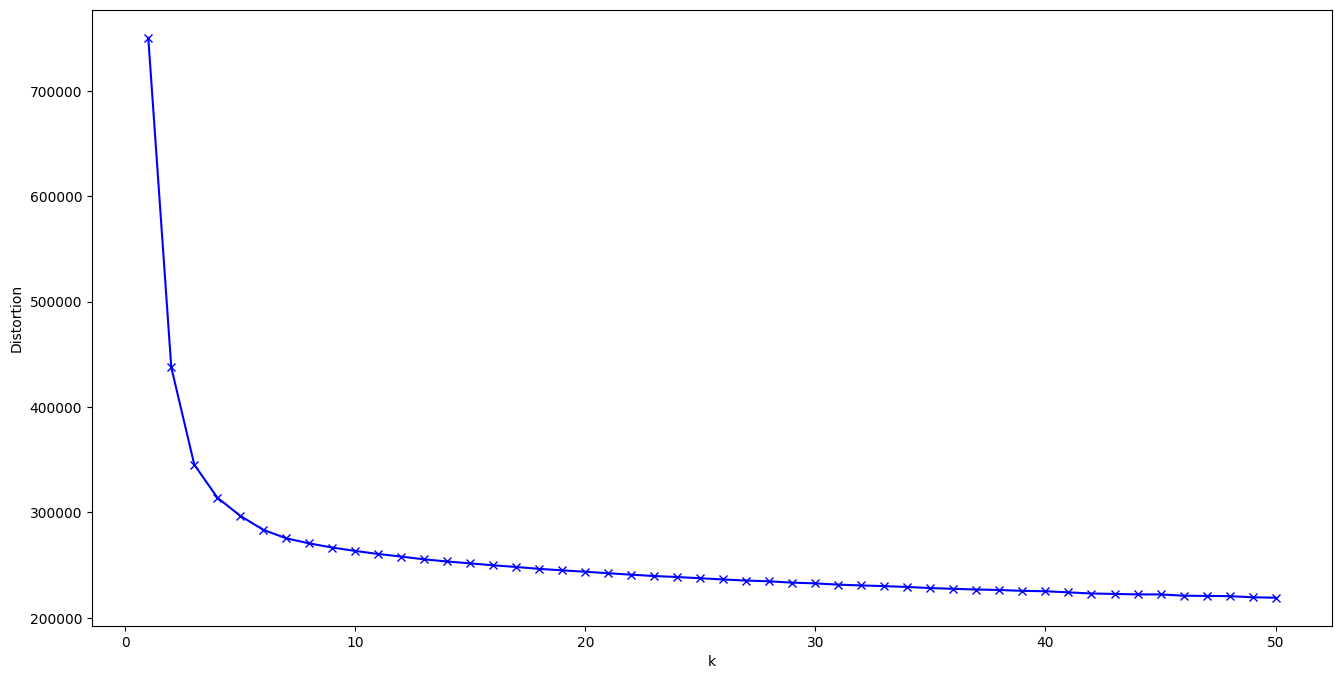

In [32]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

distortions = []
K = range(1,51)
for k in tqdm(K):
    kmeanModel = KMeans(n_clusters=k, n_init=10, random_state=0)
    kmeanModel.fit(reshaped_vectors)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.show()

In [36]:
# Convert email_vectors list to numpy array
email_vectors = np.array(email_vectors)

# Make predictions using the trained KMeans model
predictions = kmeans.predict(reshaped_vectors)

# Use t-SNE to reduce the BERT embeddings to two dimensions
tsne = TSNE(n_components=2, random_state=0)
email_vectors_2d = tsne.fit_transform(email_vectors)

# Create a scatter plot of the t-SNE reduced embeddings, colored by cluster assignment
plt.figure(figsize=(16, 16))
plt.scatter(email_vectors_2d[:, 0], email_vectors_2d[:, 1], c=predictions)
plt.show()

ValueError: Found array with dim 3. TSNE expected <= 2.

In [ ]:

# n_batches = 10

# # Calculate the batch size
# batch_size = len(email_vectors) // n_batches

# # Initialize the KMeans model
# kmeans = MiniBatchKMeans(n_clusters=10)

# # Fit the model one batch at a time
# for i in tqdm(range(n_batches)):
#     start = i * batch_size
#     end = (i + 1) * batch_size
#     kmeans.partial_fit(email_vectors[start:end])

# # If there are any remaining vectors, fit them as well
# if len(email_vectors) % n_batches != 0:
#     kmeans.partial_fit(email_vectors[n_batches * batch_size:])

# # Print cluster assignments


In [ ]:
from joblib import dump
dump(kmeans, 'kmeans.joblib')